# Identification of the type of glass present at the scene of a crime

In [10]:
%matplotlib nbagg
import pandas as pd 
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, tree
from sklearn.neighbors import NearestCentroid, KNeighborsClassifier
from sklearn.model_selection import train_test_split
import math
import json
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
import matplotlib.widgets
from sklearn.metrics import ConfusionMatrixDisplay

## Preprocessing

The data was first converted into a DataFrame, for ease of analysis. Data, which was not needed, such as date collected, was removed.

Missing data was replaced using the mean for that entire column based on the glass type. If a row had more than 3 missing variables, it was removed altogether, to avoid it skewing the dataset.    

Standard scaling was used to ensure every column has the same weight in the model, by transforming the data so it has a mean of 0 and a standard deviation of 1.  This increases the reliability of the data points.

In [11]:
# Loading UK data
UK_data = pd.read_csv('data/glass_uk.csv')
UK_data = UK_data.drop(axis = 1, columns = ["Unnamed: 0", "Date Collected", "UUID"])

# Loading US data
with open ('data/glass_us.json') as f:
    glass_us = json.load(f)

# Converting the json file into DataFrame
US_data = pd.DataFrame(glass_us.items(), columns = ['Organisation', 'properties']).explode('properties')
US_data = pd.json_normalize(json.loads(US_data.to_json(orient='records'))) 

# Renaming columns
US_data = US_data.rename(columns = {'properties.RI':'RI', 'properties.Na':'Na','properties.Mg':'Mg','properties.Al':'Al','properties.Si':'Si',
                      'properties.K':'K','properties.Ca':'Ca','properties.Ba':'Ba','properties.Fe':'Fe','properties.Type':'Type',
                      'properties.Date Collected':'Date Collected','properties.State':'State'}) 

# Removing unnecessary columns
US_data = US_data.drop(['Organisation', 'State', 'Date Collected'], axis = 1).astype({'Type':'int'}) 

# Loading EU data
with open ('data/glass_eu.json') as f:
    glass_eu = json.load(f)

EU_data = pd.DataFrame(glass_eu.values())
EU_data = EU_data.drop(['Supervisor', 'Initials', 'Date Collected'], axis = 1)

# Concatenating data together
glass_data = pd.concat([UK_data, US_data, EU_data], ignore_index = True)

In [13]:
# Removing rows with more than 3 missing values
index = []
for i in range(len(glass_data)):
    NaNsum = glass_data.iloc[i].isnull().sum()
    if NaNsum >= 3:
        index.append(i)
glass_data = glass_data.drop(index, axis = 0)

# Replacing NaN values with mean for each type
columns = ['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe', 'Type'] 

def replace_nan_values(file, column):
    """
    Takes a dataframe and a column. 
    Replaces nan values inside the column with a mean value for this column, depending on glass type.
    """
    mean_values = []
    df_replaced_list = []

    for i in range (1,8):
        UK_data_replaced = file.query(f"Type == {i}")[column] # Chooses only one column
        mean_values.append(UK_data_replaced.mean(skipna = True)) # Calculates mean for each type in only one chosen column
        replaced = UK_data_replaced.fillna(mean_values[i-1]) # Replaces nan values with the means for each type in the chosen column
        df_replaced_list.append(replaced) # Appends replaced datapoints for each type

    CONCATENATED = pd.concat(df_replaced_list) # Concatenates datapoints for each type to return full column
    CONCATENATED = CONCATENATED.sort_index(ascending = True)
    return CONCATENATED # Returns a column with replaced nan values

glass_data = replace_nan_values(glass_data, columns)

# Standard scaling
scaled = {}

for Col_j in (glass_data.iloc[:,:-1].columns): # each column except the last (type)
    mean_j = glass_data[Col_j].mean()
    std_j = glass_data[Col_j].std()
    glass_data[Col_j] = glass_data[Col_j].apply(lambda x: (x - mean_j) / std_j)  

## Finding the optimal model and improving the accuracy of results

After testing multiple models, the Random Forest classifier was found to be both the most accurate and precise. This could be because it contains multiple decision trees and finds the average of them all, improving accuracy, particularly when multiple variables need to be considered. 

A limitation of Random Forests is that imbalanced data affects the accuracy of the results. The data was balanced to overcome this by randomly selecting and duplicating data from minority classes (Random Oversampling). This is advantageous compared to undersampliing, which removes excess data from majority classes - this would lead to a significant reduction in training and testing data, which would reduce the accuracy of the model.

Random Forest was tested 10 times by altering its parameters. As the default value for n_estimators (trees in the forest) is 100, the experimental value was set to significantly higher one to see if there is a difference in accuracy. Max_depth, min_samples_split and min_samples_leaf parameters were also altered in a similar manner. Based on that, a hyperparameter could be found. 

As can be seen below, the accuracy of Random Forest with high value of n_estimators is higher compared to Random Forest with default parameters. Thus n_estimators can be treated as a hyperparameter and increased from default value to improve the accuracy of the model. However, since the increase in value, also increases computing time, the final value for the prediction was set to be 1000.

In [14]:
X = glass_data[['RI','Na','Mg','Al','Si','K','Ca','Ba','Fe']]
y = glass_data['Type']

# Data balancing
ros = RandomOverSampler(random_state = 0) 
X_resampled, y_resampled = ros.fit_resample(X.values, y)

# Spliting the data into training and testing sets with test size of 30%
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.3, shuffle = True) 

classifiers = []
model1 = NearestCentroid()
classifiers.append(model1)
model2 = svm.SVC()
classifiers.append(model2)
model3 = tree.DecisionTreeClassifier()
classifiers.append(model3)
model4 = RandomForestClassifier()
classifiers.append(model4)
model5= KNeighborsClassifier()
classifiers.append(model5)
model6 = RandomForestClassifier(n_estimators = 10000)
classifiers.append(model6)
model7 = RandomForestClassifier(max_depth = 5) # Default is none
classifiers.append(model7)
model8 = RandomForestClassifier(min_samples_split = 5) # Default is 2
classifiers.append(model8)
model9 = RandomForestClassifier(min_samples_leaf = 4) # Default is 1
classifiers.append(model9)

for clf in classifiers:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print("Accuracy of %s is %s"%(clf, acc))
    pr = precision_score(y_test, y_pred, average = 'macro')
    print("Precision of %s is %s"%(clf, pr))
    recall = recall_score(y_test, y_pred, average = 'macro')
    print("Recall of %s is %s "%(clf, recall))
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix of %s is \n %s \n"%(clf, cm))

Accuracy of NearestCentroid() is 0.5873015873015873
Precision of NearestCentroid() is 0.631192674339522
Recall of NearestCentroid() is 0.5709310039805395 
Confusion Matrix of NearestCentroid() is 
 [[ 9  1 13  0  1  0]
 [ 7  9  3  0  5  0]
 [ 7  0 11  0  1  0]
 [ 0  9  0  4  1  0]
 [ 0  0  2  0 26  0]
 [ 0  0  0  1  1 15]] 

Accuracy of SVC() is 0.6746031746031746
Precision of SVC() is 0.677608543417367
Recall of SVC() is 0.6928381001523416 
Confusion Matrix of SVC() is 
 [[ 8  3 12  1  0  0]
 [ 5  9  5  3  2  0]
 [ 4  3 11  0  1  0]
 [ 0  0  0 13  1  0]
 [ 0  0  0  0 28  0]
 [ 0  1  0  0  0 16]] 

Accuracy of DecisionTreeClassifier() is 0.8253968253968254
Precision of DecisionTreeClassifier() is 0.827943829953634
Recall of DecisionTreeClassifier() is 0.8329248366013071 
Confusion Matrix of DecisionTreeClassifier() is 
 [[12  7  4  0  0  1]
 [ 1 19  2  2  0  0]
 [ 0  0 19  0  0  0]
 [ 0  0  0 14  0  0]
 [ 0  0  0  0 28  0]
 [ 4  1  0  0  0 12]] 

Accuracy of RandomForestClassifier() is

## Effects of balancing data

The normalized confusion matrix after balancing the data shows an improvement in predictivity, as the Predicted Label equals True Label more often. This is further proved with the recall score for unbalanced and balanced data - much higher for balanced data, which suggests the balanced model more correctly identifies True Positives. 

Furthermore, due to very low number of unique data points for certain glass types, they sometimes do not appear at all in the testing set, making it impossible to test the imbalanced model (seen as empty rows in the confusion matrix for imbalanced data).

Normalizing both confusion matrices allowed to compare them, as they are based on different number of datapoints.

<IPython.core.display.Javascript object>


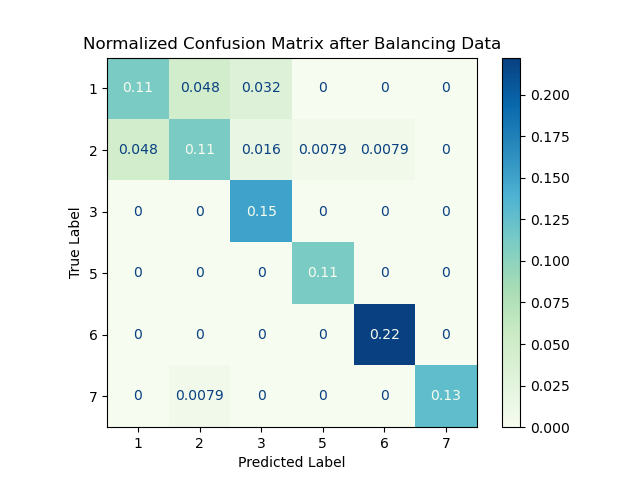

Recall after balancing data is 0.8513071895424837 


In [15]:
# Visualising the normalized confusion matrix after balancing
color = 'black'
y_pred = model6.predict(X_test)
cm = confusion_matrix(y_test, y_pred, normalize = 'all')

cm_display = ConfusionMatrixDisplay(cm, display_labels = model6.classes_).plot(cmap = plt.cm.GnBu)

plt.title('Normalized Confusion Matrix after Balancing Data')
plt.xlabel('Predicted Label', color=color)
plt.ylabel('True Label', color=color)
plt.gcf().axes[0].tick_params(colors=color)
plt.gcf().axes[1].tick_params(colors=color)
plt.show()

# Calculating recall score
recall_after = recall_score(y_test, y_pred, average = 'macro')
print("Recall after balancing data is %s "%(recall_after))

<IPython.core.display.Javascript object>


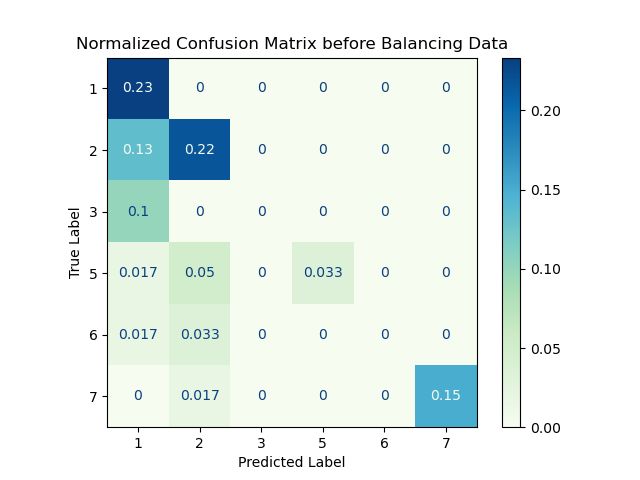

Recall before balancing data is 0.47539682539682543 


In [16]:
# Visualiing the normalized confusion matrix before balancing data
color = 'black'
X_train_before, X_test_before, y_train_before, y_test_before = train_test_split(X, y, test_size = 0.3, shuffle = True)
model6.fit(X_train_before, y_train_before)
y_pred = model6.predict(X_test_before)

cm = confusion_matrix(y_test_before, y_pred, normalize = 'all')
cm_display = ConfusionMatrixDisplay(cm, display_labels = model6.classes_).plot(cmap = plt.cm.GnBu)

plt.title('Normalized Confusion Matrix before Balancing Data')
plt.xlabel('Predicted Label', color = color)
plt.ylabel('True Label', color = color)
plt.gcf().axes[0].tick_params(colors = color)
plt.gcf().axes[1].tick_params(colors = color)
plt.show()

# Calculating recall score
recall_before = recall_score(y_test_before, y_pred, average = 'macro')
print("Recall before balancing data is %s "%(recall_before))

## Results

In the evidence data, only glass Types 1, 2 and 7 were identified. From further analysis below, it was shown that types 2 and 7 appeared far more often than Type 1. Based on this, it was concluded that the types of glass present at the scene of the crime were Types 2 and 7, as the infrequency of Type 1 suggests that it may be an outlier, due to the uncertainty of the model and possible overfitting steming from the data balancing.

As both these types of glass are not formed using the float process, the suspects were not present at the scene of the crime and are innocent.

In [17]:
# Analysing evidence data n times to get the most accurate results
samples_data = pd.read_csv('data/samples.evidence', index_col = 0, sep= ' ', )
 
def predict_n_times(X, y, n):
    """
    Takes independent (X) and dependent (y) data and perfoms fitting and prediction n times.
    Saves the predicted data for each iteration inside a dictionary called sample_analysis.
    """
    sample_analysis = {}
    for i in range(n):
        rf = RandomForestClassifier(n_estimators = 1000)
        rf.fit(X, y)
        sample_analysis["analysis_%s"%(i+1)] = []
        for row in samples_data.itertuples():
            sample_test = [row.RI, row.Na, row.Mg, row.Al, row.Si, row.K, row.Ca, row.Ba, row.Fe]
            prediction = int(rf.predict([sample_test]))
            sample_analysis["analysis_%s"%(i+1)].append(prediction)                             
    return sample_analysis

sample_analysis = predict_n_times(X_resampled, y_resampled, 10)
print(sample_analysis)
print()

# Checking how many times glass type 1 occured in the previous analysis
count = 0
for key in sample_analysis:
    if 1 in sample_analysis[key]:
        count += 1
print("Glass of type 1 occured %s time(s) when analysing the evidence 10 times."%(count))

{'analysis_1': [2, 2, 2, 2, 7, 2, 2, 2], 'analysis_2': [2, 2, 2, 2, 7, 2, 2, 2], 'analysis_3': [2, 2, 2, 2, 7, 2, 2, 2], 'analysis_4': [2, 2, 2, 2, 7, 2, 2, 2], 'analysis_5': [2, 2, 2, 2, 7, 2, 2, 2], 'analysis_6': [2, 2, 2, 2, 7, 2, 2, 2], 'analysis_7': [2, 2, 2, 2, 7, 2, 2, 2], 'analysis_8': [2, 2, 2, 2, 7, 2, 2, 2], 'analysis_9': [2, 2, 2, 2, 7, 2, 2, 2], 'analysis_10': [2, 2, 2, 2, 7, 2, 2, 2]}

Glass of type 1 occured 0 time(s) when analysing the evidence 10 times.


## The effect of different variables on the model's prediction 

Below is an interactive graph displaying how the model's accuracy varies as each glass variable is removed.  
Each time the model is run, a different variable is shown to decrease the accuracy the most. This is due to the random nature of the random forest model, as no single variable skews the data. 


In [ ]:
# Random Forest Interactive Plot
X_resampled_df = pd.DataFrame(X_resampled, columns = ['RI', 'Na', 'Mg','Al','Si','K','Ca','Ba','Fe'])
categories = ('RI', 'Na', 'Mg','Al','Si','K','Ca','Ba','Fe')
Scores = []
RF = RandomForestClassifier(n_estimators = 1000)

RF.fit(X_train, y_train)
y_pred = RF.predict(X_test)
OriginalAccuracy = accuracy_score(y_test, y_pred)

for i in categories:
    X_new = X_resampled_df.copy().drop(axis = 1, columns = [i])
    X_train, X_test, y_train, y_test = train_test_split(X_new, y_resampled, test_size = 0.3, shuffle = True)
    average = []
    # Score is different each time the code is ran, so an average is taken over 10 runs
    for n in range(10):
        RF.fit(X_train, y_train)
        y_pred = RF.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        average.append(accuracy)
    aa = np.array(average).mean()    
    Scores.append(aa)
    
# Interactive plot
Variables = ['RI', 'Na', 'Mg','Al','Si','K','Ca','Ba','Fe']
scoresDict = dict(zip(Variables, Scores))
fig, ax = plt.subplots()
plt.subplots_adjust(left=0.45)
ax.set_xlabel('Glass Variable')
ax.set_ylabel('Score')

bars = {}
colours = plt.get_cmap("Pastel1").colors

for i, variable in enumerate(categories):
    if i == 0:
        bars[variable] = ax.bar(Variables[i], Scores[i], color = colours[i], alpha = 0.5)
        fig.text(0.01, 0.95, 'Original Score is %s'%(OriginalAccuracy))
        text = fig.text(0.01,0.9,'Score without %s is %s'%(Variables[i], scoresDict[Variables[i]]))
        plt.title('Random Forest')
        
    else:
        bars[variable] = ax.bar(Variables[i], Scores[i], color=colours[i], alpha = 0.13)

# Creating the radio buttons
button_box = plt.axes([0.01,0.2,0.3, 0.5], facecolor ='#d5e8d1')
radio = matplotlib.widgets.RadioButtons(button_box, categories)

# Function updates text to display score
def showtext(name):
    text.set_text('Score without %s is %s'%(name, scoresDict[name]))
    return text

# Callback Function when radio button is pressed
def callback(label):
    for name, bar in bars.items():
        if name == label:
            bar[0].set_alpha(1) 
            showtext(name)
        else:
            bar[0].set_alpha(0.15) 
    return
      
radio.on_clicked(callback)
plt.show()

## Random Forest vs SVC

When compared to the Random Forest, the SVC classifier has a lower score overall, regardless of the variable removed. This further justifies our choice of using the Random Forest as out main analysis technique.

<IPython.core.display.Javascript object>


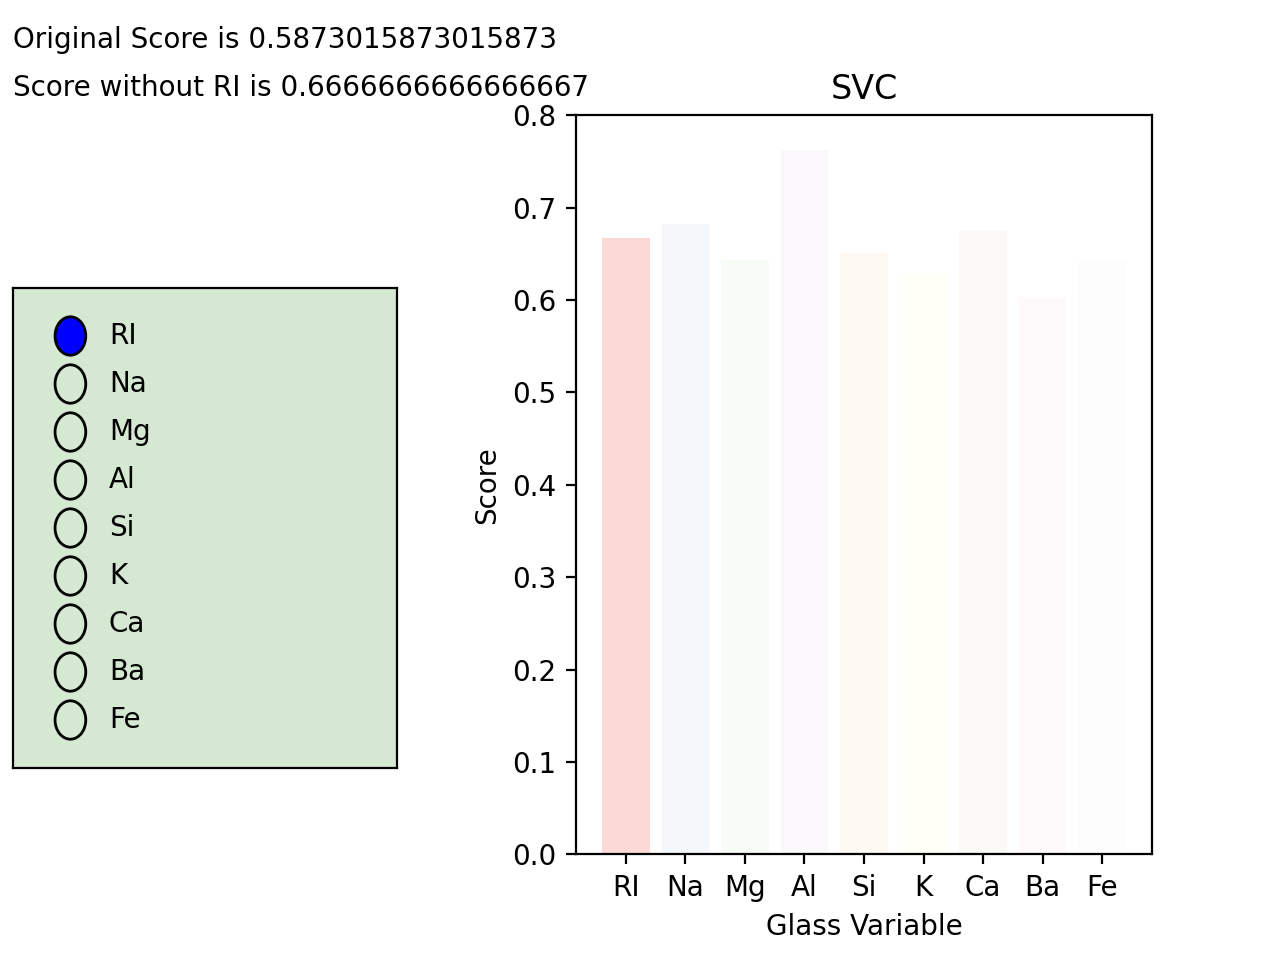

In [24]:
# SVC Interactive Plot
X_resampled_df = pd.DataFrame(X_resampled, columns = ['RI', 'Na', 'Mg','Al','Si','K','Ca','Ba','Fe'])
categories = ('RI', 'Na', 'Mg','Al','Si','K','Ca','Ba','Fe')
Scores = []

model2.fit(X_train, y_train)
y_pred = model2.predict(X_test)
OriginalAccuracy = accuracy_score(y_test, y_pred)


for i in categories:
    X_new = X_resampled_df.copy().drop(axis = 1, columns = [i])
    X_train, X_test, y_train, y_test = train_test_split(X_new, y_resampled, test_size = 0.3, shuffle = True)
    average = []
    #Score is different each time the code is ran, so an average is taken over 10 runs
    for n in range(10):
        model2.fit(X_train, y_train)
        y_pred = model2.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        average.append(accuracy)
    aa = np.array(average).mean()    
    Scores.append(aa)
    
#Interactive plot
Variables = ['RI', 'Na', 'Mg','Al','Si','K','Ca','Ba','Fe']
scoresDict = dict(zip(Variables, Scores))
fig, ax = plt.subplots()
plt.subplots_adjust(left=0.45)
ax.set_xlabel('Glass Variable')
ax.set_ylabel('Score')

bars = {}
colours = plt.get_cmap("Pastel1").colors

for i, variable in enumerate(categories):
    if i == 0:
        bars[variable] = ax.bar(Variables[i], Scores[i], color=colours[i], alpha = 0.5)
        fig.text(0.01, 0.95, 'Original Score is %s'%(OriginalAccuracy))
        text = fig.text(0.01,0.9,'Score without %s is %s'%(Variables[i], scoresDict[Variables[i]]))
        plt.title('SVC')
        
    else:
        bars[variable] = ax.bar(Variables[i], Scores[i], color=colours[i], alpha = 0.13)

# Creating the radio buttons
button_box = plt.axes([0.01,0.2,0.3, 0.5], facecolor = '#d5e8d1')
radio = matplotlib.widgets.RadioButtons(button_box, categories)


# Function updates text to display score
def showtext(name):
    text.set_text('Score without %s is %s'%(name, scoresDict[name]))
    return text

# Callback Function when radio button is pressed
def callback(label):
    for name, bar in bars.items():
        if name == label:
            bar[0].set_alpha(1) 
            showtext(name)
        else:
            bar[0].set_alpha(0.15) 
    return
      
radio.on_clicked(callback)
plt.show()